In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import glob
import numpy as np
import pandas as pd

In [3]:
import tifffile
from PIL import Image
from umap import umap_
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import squareform

In [4]:
import my_cajal
import my_run_gw
from cajal import utilities

# Same formulations

### Specify inputs

In [9]:
#retrieve all file names for all masked images
paths = ['241208_160806_jg_ve_norha_mw_encapsulation_dapi_phal_d7_40k_60k/241208_160806_Plate 1/#24B2570319_ZProj',
         '241208_174217_jg_ve_norha_mw_encapsulation_dapi_phal_d7_peg_10k/241208_174217_Plate 1/#24B2570319_ZProj',
         '241125_192553_jg_ve_norha_mw_encapsulation_dapi_phal_d3_peg_10k/241125_193216_Plate 1/#24B2570319_ZProj',
         '241126_091801_jg_ve_norha_mw_encapsulation_dapi_phal_d3_40k_60k/241126_091801_Plate 1/#24B2570319_ZProj',
         '241208_124427_jg_ve_norha_mw_encapsulation_dapi_phal_d14_peg_10k/241208_124736_Plate 1/#24B2570319_ZProj',
         '241208_144351_jg_ve_norha_mw_encapsulation_dapi_phal_d14_40k_60k/241208_144351_Plate 1/#24B2570319_ZProj']
paths = ['/mnt/z/James/norbornene homopolymerization/same_formulations/' + p for p in paths]
files = [glob.glob(path+'/*TRITC 556,600]_001_masks_corrected.png') for path in paths]
files = np.array([f for sublist in files for f in sublist])
len(files)

236

In [10]:
#where to ouput cajal outputs (distance matrices)
out_path = '/mnt/z/James/norbornene homopolymerization/same_formulations/cajal/'

In [11]:
#convert from np array to list
files = [str(f) for f in files]

### Calculate intracellular distance matrices

In [11]:
#initialize meta file to include file names and file ID (file_XXX)
pd.DataFrame([files,['file_'+str(i) for i in range(len(files))]]).T.to_csv(out_path+'/meta.csv')

#compute intracellular distance matrices for all masks in all images
out_csv=out_path+"/tiff_sampled_50.csv"
my_cajal.compute_icdm_all(
               out_path,
               out_csv,
               files, #explicitly defined file list instead of just directory
               n_sample = 50,
               num_processes = 8,
               background = 0,
               discard_cells_with_holes = False,
               only_longest = False,
               area_cutoff = 400) #area cutoff was added to remove most erroneous cell masks 

### Calculate GW distance matrix

In [12]:
#compute GW distance between all masks in all images
a,b = my_run_gw.my_compute_gw_distance_matrix(
                out_path+"/tiff_sampled_50.csv",
                out_path+"/gw_dmat.csv",
                num_processes=6,
                gw_coupling_mat_csv_loc=out_path+"/coupling_mat.csv",
                return_coupling_mats=True)

  0%|          | 0/10531755 [00:00<?, ?it/s]

In [ ]:
#create square distance matrix from file saved by my_compute_gw_distance_matrix()
gw_df = pd.read_csv(out_path+'/gw_dmat.csv',header=None,engine='pyarrow') #read in data
gw_df.rename(columns={0: 'cell1', 1: 'cell2', 2: 'dist', 3: 'method'}, inplace=True) #rename columns
gw_df[['cell1', 'cell2']] = np.sort(gw_df[['cell1', 'cell2']].values, axis=1) #sort cell pairs so squareform creates matrix correctly

gw_dist = gw_df.sort_values(['cell1', 'cell2'],inplace=False)['dist'] #extract distance values from correctly ordered DF
gw_dist = squareform(gw_dist, force="tomatrix")

### Fill out metadata

In [ ]:
#read initialized meta file and populate with other information
meta = pd.read_csv(out_path+'/meta.csv',index_col=0)
meta.columns = ['file_name','file_id']
meta['day'] = [c.split('phal_')[1].split('_')[0] for c in meta['file_name']]
meta['well'] = [c.split('_ZProj/')[1].split('ROI')[0] for c in meta['file_name']]
meta['polymer'] = '4-arm PEG'
meta.loc[['B' in t for t in meta['well']],'polymer'] = 'NorHA8'
meta.loc[['C' in t for t in meta['well']],'polymer'] = 'NorHA18'
meta.loc[['D' in t for t in meta['well']],'polymer'] = 'NorHA40'

In [36]:
cells = sorted(list(set(gw_df['cell1'].tolist() + gw_df['cell2'].tolist())))
cell_file = pd.DataFrame(['_'.join(c.split('_')[:2]) for c in cells],columns=['file_id'])

### Create 2D embedding of GW distance matrix

In [ ]:
# Compute UMAP representation
reducer = umap_.UMAP(metric="precomputed", random_state=1)
embedding = reducer.fit_transform(gw_dist)
embedding = pd.DataFrame(embedding,columns=['Dim1','Dim2'])

In [31]:
# Cluster cells into subpopulations
embedding['leiden'] = utilities.leiden_clustering(gw_dist, seed=1, nn=10, resolution=0.005)
len(np.unique(embedding['leiden']))

# Add meta data to embedding DF
embedding['file_id'] = ['_'.join(c.split('_')[:2]) for c in cells]
embedding = embedding.merge(meta,on='file_id')
embedding['mask'] = [c.split('_')[-1] for c in cells] # assign each data point to its corresponding mask in its file

29

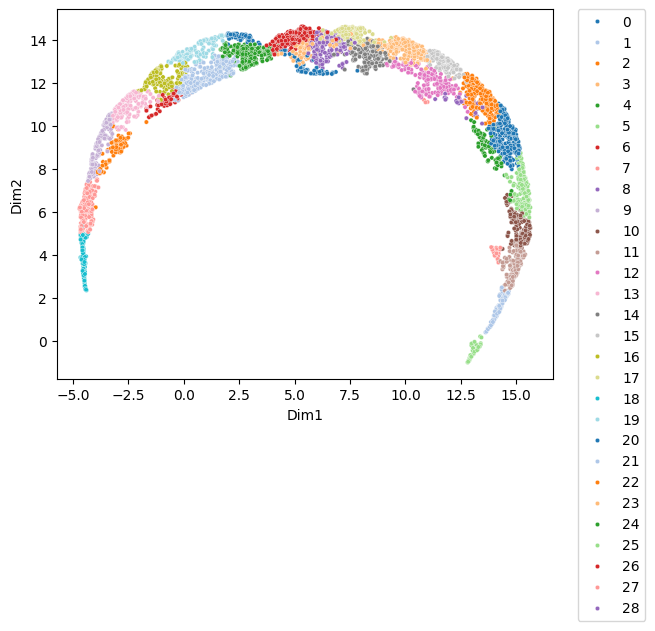

In [33]:
#Visualize different clusters
sns.scatterplot(embedding,x='Dim1',y='Dim2',hue='leiden',s=10,palette='tab20')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

<Axes: xlabel='Dim1', ylabel='Dim2'>

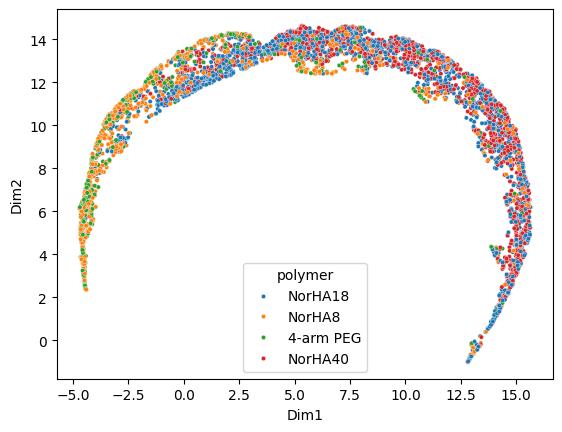

In [48]:
#Visualize cells in different hydrogel groups
sns.scatterplot(embedding,x='Dim1',y='Dim2',hue='polymer',s=10)

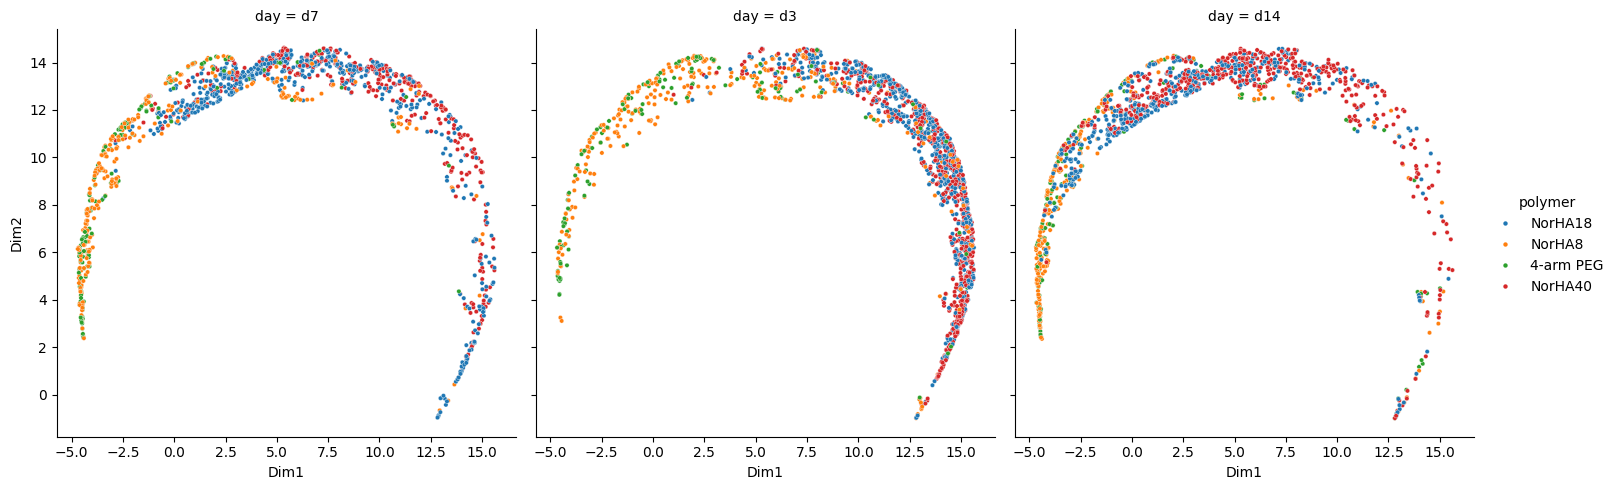

In [38]:
#Visualize cells in different hydrogel groups at each time point
sns.relplot(embedding,x='Dim1',y='Dim2',hue='polymer',s=10,col='day',kind='scatter')

### Identify cluster medoid cells

In [41]:
# Identify cluster medoids (representative cells for each cluster)
medoids = []

for c in embedding['leiden'].unique():
    cluster_cells = np.array(cells)[np.where(embedding['leiden']==c)] #identify which cells are in the cluster c
    # subset gw_df to contain only cell-cell distances between only cluster c cells
    sub_df = gw_df[gw_df['cell1'].isin(cluster_cells)].drop('method',axis=1) 
    sub_df = sub_df[sub_df['cell2'].isin(cluster_cells)]
    # find medoids with identify_medoids()
    cluster_gw = sub_df.set_index(['cell1','cell2']).to_dict()['dist']
    medoids.append(utilities.identify_medoid(cluster_cells, cluster_gw))
    print(c)

6
22
14
1
4
17
2
8
3
9
25
13
21
16
20
19
7
10
12
27
18
23
28
15
0
11
26
5
24


In [ ]:
# add medoid status column to embedding DF
embedding['medoid_cell'] = [c in medoids for c in cells]
embedding.to_csv(out_path+'/embedding_df_gw.csv') # save embedding file for plotting in R
embedding_medoid = embedding[embedding['medoid_cell']==True]

### Output medoid cell masks as binary pictures

In [220]:
from skimage.measure import regionprops_table, label

In [52]:
os.makedirs(out_path +'cluster_medoids/', exist_ok=True)

for f,m,c in zip(embedding_medoid['file_name'],embedding_medoid['mask'],embedding_medoid['leiden']):
    #im = np.array(tifffile.imread(f)) == int(m)
    im = (label(np.array(Image.open(os.path.join(f)))[:,:,0])-1) == int(m)
    
    B = np.argwhere(im)
    (ystart, xstart), (ystop, xstop) = B.min(0)-1, B.max(0) + 1 
    im = im[ystart:ystop, xstart:xstop]
    
    plt.imsave(out_path +'cluster_medoids/cluster_'+str(c)+'.png', 1-im, cmap='gray')

### Output all cell masks of each cluster as binary pictures

In [263]:
cluster_masks = [[np.empty(shape=(0,0))] for c in embedding['leiden'].unique()]
for i,f in enumerate(files):
    m = label(np.array(Image.open(os.path.join(f)))[:,:,0])-1
    for j,c in enumerate(embedding['leiden'].unique()):
        spec_masks = embedding.loc[(embedding['file_name'] == f) & (embedding['leiden']==c),'mask']
        
        # Get properties of each region (mask)
        regions = pd.DataFrame(regionprops_table(m*np.isin(m,np.array(spec_masks,dtype='int')),properties=('label', 'bbox')))

        # Extract and pad each mask
        clipped_masks = []
        for index, row in regions.iterrows():
            lab, min_row, min_col, max_row, max_col = (row['label'],row['bbox-0'],row['bbox-1'],row['bbox-2'],row['bbox-3'])#region.bbox
            mask = (m[min_row:max_row, min_col:max_col] == lab).astype(np.uint8)
            #padded_mask = pad(mask, padding, mode='constant')
            clipped_masks.append(mask)

        cluster_masks[j].append(clipped_masks)

In [264]:
cluster_masks = [[c for cs in css for c in cs] for css in cluster_masks]
[c.sort(key=lambda x: x.shape[0] * x.shape[1], reverse=True) for c in cluster_masks];

In [266]:
os.makedirs(out_path +'cluster_masks/', exist_ok=True)

for c,clipped_masks in zip(embedding['leiden'].unique(),cluster_masks):
    # Calculate grid dimensions
    n_masks = len(clipped_masks)
    grid_size = int(np.ceil(np.sqrt(n_masks)))

    if n_masks > 0:
        # Calculate the size of the grid canvas
        max_height = max(mask.shape[0] for mask in clipped_masks)
        max_width = max(mask.shape[1] for mask in clipped_masks)
        padding = int(0.1*max_height)
        grid_height = grid_size * (max_height + padding) #- padding
        grid_width = grid_size * (max_width + padding) #- padding

        # Create the grid canvas
        grid_canvas = np.zeros((grid_height, grid_width), dtype=np.uint8)

        # Place masks in the grid
        for i, mask in enumerate(clipped_masks):
            row = i // grid_size
            col = i % grid_size
            y_start = row * (max_height + padding) + padding
            x_start = col * (max_width + padding) + padding
            y_end = y_start + mask.shape[0]
            x_end = x_start + mask.shape[1]
            grid_canvas[y_start:y_end, x_start:x_end] = mask# * (i + 1)  # Use (i + 1) as the label


        plt.imsave(out_path +'cluster_masks/cluster_'+str(c)+'.png', grid_canvas>0, cmap='gray_r')
        print(c)

6
22
14
1
4
17
2
8
3
9
25
13
21
16
20
19
7
10
12
27
18
23
28
15
0
11
26
5
24


# Same mechanics

### Specify inputs

In [12]:
paths = ['241218_112544_jg_ve_norha_mw_encapsulation_stiff_match_dapi_phal_d3_peg_10k/241218_134630_Plate 2/#24B2570319_ZProj',
         '241218_143216_jg_ve_norha_mw_encapsulation_stiff_match_dapi_phal_d3_40k_60k/241218_143532_Plate 1/#24B2570319_ZProj',
         '241221_122140_jg_ve_norha_mw_encapsulation_stiff_match_dapi_phal_d7_peg_10k/241221_122140_Plate 1/#24B2570319_ZProj',
         '241221_133248_jg_ve_norha_mw_encapsulation_stiff_match_dapi_phal_d7_40k_60k/241221_133248_Plate 1/#24B2570319_ZProj',
         '241229_114731_jg_ve_norha_mw_encapsulation_stiff_match_dapi_phal_d14_all_samples/241229_114731_Plate 1/#24B2570319_ZProj']
paths = ['/mnt/z/James/norbornene homopolymerization/same_mechanics/' + p for p in paths]
files = [glob.glob(path+'/*TRITC 556,600]_001_masks_corrected.png') for path in paths]
files = np.array([f for sublist in files for f in sublist])
len(files)

238

In [13]:
out_path = '/mnt/z/James/norbornene homopolymerization/same_mechanics/cajal/'

In [14]:
files = [str(f) for f in files]

### Calculate intracellular distance matrices

In [15]:
#initialize meta file to include file names and file ID (file_XXX)
pd.DataFrame([files,['file_'+str(i) for i in range(len(files))]]).T.to_csv(out_path+'/meta.csv')

#compute intracellular distance matrices for all masks in all images
out_csv=out_path+"/tiff_sampled_50.csv"
my_cajal.compute_icdm_all(
               out_path,
               out_csv,
               files, #explicitly defined file list instead of just directory
               n_sample = 50,
               num_processes = 8,
               background = 0,
               discard_cells_with_holes = False,
               only_longest = False,
               area_cutoff = 400) #area cutoff was added to remove most erroneous cell masks 

### Calculate GW distance matrix

In [16]:
#compute GW distance between all masks in all images
a,b = my_run_gw.my_compute_gw_distance_matrix(
                out_path+"/tiff_sampled_50.csv",
                out_path+"/gw_dmat.csv",
                num_processes=6,
                gw_coupling_mat_csv_loc=out_path+"/coupling_mat.csv",
                return_coupling_mats=True)

  0%|          | 0/2172570 [00:00<?, ?it/s]

In [ ]:
#create square distance matrix from file saved by my_compute_gw_distance_matrix()
gw_df = pd.read_csv(out_path+'/gw_dmat.csv',header=None,engine='pyarrow') #read in data
gw_df.rename(columns={0: 'cell1', 1: 'cell2', 2: 'dist', 3: 'method'}, inplace=True) #rename columns
gw_df[['cell1', 'cell2']] = np.sort(gw_df[['cell1', 'cell2']].values, axis=1) #sort cell pairs so squareform creates matrix correctly

gw_dist = gw_df.sort_values(['cell1', 'cell2'],inplace=False)['dist'] #extract distance values from correctly ordered DF
gw_dist = squareform(gw_dist, force="tomatrix")

### Fill out metadata

In [ ]:
#read initialized meta file and populate with other information
meta = pd.read_csv(out_path+'/meta.csv',index_col=0)
meta.columns = ['file_name','file_id']
meta['day'] = [c.split('phal_')[1].split('_')[0] for c in meta['file_name']]
meta['well'] = [c.split('_ZProj/')[1].split('ROI')[0] for c in meta['file_name']]
meta['polymer'] = '4-arm PEG'
meta.loc[['B' in t for t in meta['well']],'polymer'] = 'NorHA8'
meta.loc[['C' in t for t in meta['well']],'polymer'] = 'NorHA18'
meta.loc[['D' in t for t in meta['well']],'polymer'] = 'NorHA40'

In [62]:
cells = sorted(list(set(gw_df['cell1'].tolist() + gw_df['cell2'].tolist())))
cell_file = pd.DataFrame(['_'.join(c.split('_')[:2]) for c in cells],columns=['file_id'])

### Create 2D embedding of GW distance matrix

In [ ]:
# Compute UMAP representation
reducer = umap_.UMAP(metric="precomputed", random_state=1)
embedding = reducer.fit_transform(gw_dist)
embedding = pd.DataFrame(embedding,columns=['Dim1','Dim2'])

In [64]:
# Cluster cells into subpopulations
embedding['leiden'] = utilities.leiden_clustering(gw_dist, seed=1, nn=10, resolution=0.015)
len(np.unique(embedding['leiden']))

# Add meta data to embedding DF
embedding['file_id'] = ['_'.join(c.split('_')[:2]) for c in cells]
embedding = embedding.merge(meta,on='file_id')
embedding['mask'] = [c.split('_')[-1] for c in cells] # assign each data point to its corresponding mask in its file

27

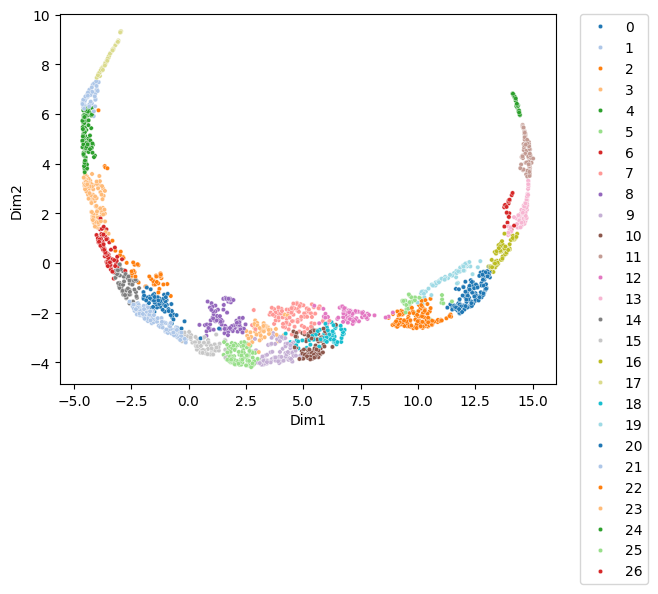

In [65]:
#Visualize different clusters
sns.scatterplot(embedding,x='Dim1',y='Dim2',hue='leiden',s=10,palette='tab20')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

<Axes: xlabel='Dim1', ylabel='Dim2'>

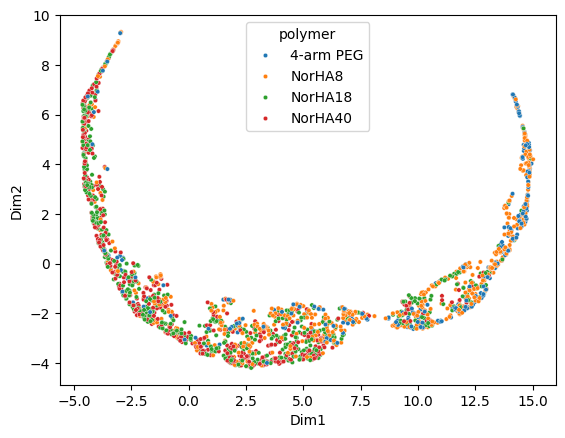

In [76]:
#Visualize cells in different hydrogel groups
sns.scatterplot(embedding,x='Dim1',y='Dim2',hue='polymer',s=10)

### Identify cluster medoid cells

In [69]:
medoids = []

for c in embedding['leiden'].unique():
    cluster_cells = np.array(cells)[np.where(embedding['leiden']==c)]
    sub_df = gw_df[gw_df['cell1'].isin(cluster_cells)].drop('method',axis=1)
    sub_df = sub_df[sub_df['cell2'].isin(cluster_cells)]
    cluster_gw = sub_df.set_index(['cell1','cell2']).to_dict()['dist']

    medoids.append(utilities.identify_medoid(cluster_cells, cluster_gw))
    print(c)

12
18
16
24
0
23
7
10
19
11
13
3
2
15
20
26
4
8
17
21
22
5
25
6
1
14
9


In [ ]:
# add medoid status column to embedding DF
embedding['medoid_cell'] = [c in medoids for c in cells]
embedding.to_csv(out_path+'/embedding_df_gw.csv') # save embedding file for plotting in R
embedding_medoid = embedding[embedding['medoid_cell']==True]

### Output medoid cell masks as binary pictures

In [78]:
from skimage.measure import regionprops_table, label

In [79]:
os.makedirs(out_path +'cluster_medoids/', exist_ok=True)

for f,m,c in zip(embedding_medoid['file_name'],embedding_medoid['mask'],embedding_medoid['leiden']):
    #im = np.array(tifffile.imread(f)) == int(m)
    im = (label(np.array(Image.open(os.path.join(f)))[:,:,0])-1) == int(m)
    
    B = np.argwhere(im)
    (ystart, xstart), (ystop, xstop) = B.min(0)-1, B.max(0) + 1 
    im = im[ystart:ystop, xstart:xstop]
    
    plt.imsave(out_path +'cluster_medoids/cluster_'+str(c)+'.png', 1-im, cmap='gray')

### Output all cell masks of each cluster as binary pictures

In [80]:
cluster_masks = [[np.empty(shape=(0,0))] for c in embedding['leiden'].unique()]
for i,f in enumerate(files):
    m = label(np.array(Image.open(os.path.join(f)))[:,:,0])-1
    #os.makedirs(os.path.dirname(re.sub('same_formulations','same_formulations/cajal/cluster_masks',f)), exist_ok=True)
    for j,c in enumerate(embedding['leiden'].unique()):
        spec_masks = embedding.loc[(embedding['file_name'] == f) & (embedding['leiden']==c),'mask']
        
        # Get properties of each region (mask)
        regions = pd.DataFrame(regionprops_table(m*np.isin(m,np.array(spec_masks,dtype='int')),properties=('label', 'bbox')))

        # Extract and pad each mask
        clipped_masks = []
        for index, row in regions.iterrows():
            lab, min_row, min_col, max_row, max_col = (row['label'],row['bbox-0'],row['bbox-1'],row['bbox-2'],row['bbox-3'])#region.bbox
            mask = (m[min_row:max_row, min_col:max_col] == lab).astype(np.uint8)
            #padded_mask = pad(mask, padding, mode='constant')
            clipped_masks.append(mask)

        cluster_masks[j].append(clipped_masks)

In [81]:
cluster_masks = [[c for cs in css for c in cs] for css in cluster_masks]
[c.sort(key=lambda x: x.shape[0] * x.shape[1], reverse=True) for c in cluster_masks];

In [83]:
os.makedirs(out_path +'cluster_masks/', exist_ok=True)

for c,clipped_masks in zip(embedding['leiden'].unique(),cluster_masks):
    # Calculate grid dimensions
    n_masks = len(clipped_masks)
    grid_size = int(np.ceil(np.sqrt(n_masks)))

    if n_masks > 0:
        # Calculate the size of the grid canvas
        max_height = max(mask.shape[0] for mask in clipped_masks)
        max_width = max(mask.shape[1] for mask in clipped_masks)
        padding = int(0.1*max_height)
        grid_height = grid_size * (max_height + padding) #- padding
        grid_width = grid_size * (max_width + padding) #- padding

        # Create the grid canvas
        grid_canvas = np.zeros((grid_height, grid_width), dtype=np.uint8)

        # Place masks in the grid
        for i, mask in enumerate(clipped_masks):
            row = i // grid_size
            col = i % grid_size
            y_start = row * (max_height + padding) + padding
            x_start = col * (max_width + padding) + padding
            y_end = y_start + mask.shape[0]
            x_end = x_start + mask.shape[1]
            grid_canvas[y_start:y_end, x_start:x_end] = mask# * (i + 1)  # Use (i + 1) as the label


        plt.imsave(out_path +'cluster_masks/cluster_'+str(c)+'.png', grid_canvas>0, cmap='gray_r')
        print(c)

12
18
16
24
0
23
7
10
19
11
13
3
2
15
20
26
4
8
17
21
22
5
25
6
1
14
9
